# 3.1 线性回归

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [5]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [7]:
n = 10000
a = tf.ones([n])
b = tf.ones([n])
c = tf.Variable(tf.zeros(n))
timer = Timer()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{timer.stop():.5f} sec'

'7.33347 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop(): .5f} sec'

' 0.00100 sec'

In [12]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

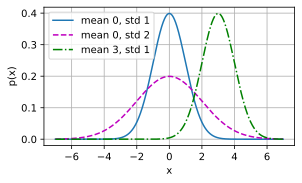

In [15]:
x = np.arange(-7, 7, 0.01)
# mu and sigma
params = [(0, 1), (0, 2), (3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', 
         figsize=(4.5,2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 3.2 线性回归从零开始实现

In [16]:
# 构造数据
def synthtic_data(w, b, num_examples):
    '''生成y=wx+b+noise'''
    x = tf.zeros((num_examples, w.shape[0]))
    x += tf.random.normal(shape=x.shape)
    y = tf.matmul(x, tf.reshape(w, (-1,1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1,1))
    return x,y
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthtic_data(true_w, true_b, 1000)

In [19]:
print('features:', features[0], 'labels:', labels[0])

features: tf.Tensor([ 2.1054592  -0.83702433], shape=(2,), dtype=float32) labels: tf.Tensor([11.279934], shape=(1,), dtype=float32)


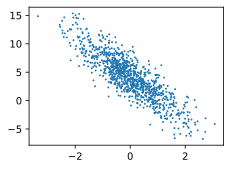

In [20]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [21]:
import random
def data_iter(batch_size, features, labels):
    '''读取数据集'''
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j) # 按照j对features做切片

In [22]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 1.076436   -0.5808394 ]
 [-0.5426087  -0.09432692]
 [-1.6739855  -0.20821595]
 [-0.338246   -2.4627013 ]
 [-0.9618714   1.3214358 ]
 [ 0.34196848  0.8309438 ]
 [ 1.7999799   0.9595505 ]
 [-0.3843159   1.5462534 ]
 [-0.738075   -0.60440326]
 [ 0.33839056 -0.38594243]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 8.338337 ]
 [ 3.4386027]
 [ 1.5715847]
 [11.880962 ]
 [-2.2148345]
 [ 2.066958 ]
 [ 4.539291 ]
 [-1.8116679]
 [ 4.778042 ]
 [ 6.184145 ]], shape=(10, 1), dtype=float32)


In [24]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

In [25]:
# 定义模型
def linreg(X, w, b):
    return tf.matmul(X, w) + b

In [26]:
# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2

In [27]:
# 定义优化算法
def sgd(params, grads, lr, batch_size):
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

In [29]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)
        dw, db = g.gradient(l, [w, b])
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epcoh: {epoch + 1}, loss:{float(tf.reduce_mean(train_l))}:f')

epcoh: 1, loss:5.067530582891777e-05:f
epcoh: 2, loss:5.067817255621776e-05:f
epcoh: 3, loss:5.070305633125827e-05:f


In [30]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [ 0.00037503 -0.00053406]
b的估计误差: [-0.00017309]


# 3.3 线性回归的简洁实现

In [32]:
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [34]:
# 生成数据集
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, num_examples=1000)

In [35]:
# 读取数据集
def load_array(data_arrays, batch_size, is_train=True):
    '''构造迭代器
    is_train:是否在每个迭代周期将数据打乱
    '''
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset  = dataset.batch(batch_size)
    return dataset
batch_size = 10
data_iter = load_array((features,labels), batch_size=batch_size)

In [38]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 0.65877414,  0.05396835],
        [ 1.0527794 ,  1.1842372 ],
        [-0.34128618,  1.0428398 ],
        [ 1.4212224 , -0.16353802],
        [ 1.6201181 ,  0.83234847],
        [-1.4098719 , -1.2916749 ],
        [ 0.38838902,  2.0162525 ],
        [-0.54976207, -0.01538601],
        [-2.2728183 , -0.42852902],
        [-1.0607196 , -1.4246807 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 5.3427534],
        [ 2.275214 ],
        [-0.0271338],
        [ 7.593068 ],
        [ 4.6276064],
        [ 5.7685966],
        [-1.8690455],
        [ 3.156852 ],
        [ 1.1005776],
        [ 6.9249773]], dtype=float32)>)

In [40]:
# 定义模型
initializer = tf.initializers.RandomNormal(stddev=0.01)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

In [41]:
# 定义损失函数 loss
loss = tf.keras.losses.MeanSquaredError()

In [42]:
# 定义优化算法
trainer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [45]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for x,y in data_iter:
        with tf.GradientTape() as tape:
            l = loss(net(x, training=True), y)
        grads = tape.gradient(l, net.trainable_variables)
        trainer.apply_gradients(zip(grads, net.trainable_variables))
    l = loss(net(features), labels)
    print(f'epoch: {epoch+1}, loss: {l:f}')

epoch: 1, loss: 0.000311
epoch: 2, loss: 0.000103
epoch: 3, loss: 0.000102


In [49]:
w = net.get_weights()[0]
print('w的估计误差：', true_w - tf.reshape(w, true_w.shape))
b = net.get_weights()[1]
print('b的估计误差：', true_b - b)

w的估计误差： tf.Tensor([-3.092289e-04  8.368492e-05], shape=(2,), dtype=float32)
b的估计误差： [0.00082874]


In [50]:
b

array([4.199171], dtype=float32)